In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
from image_et.core import ET, Patch
from image_et.utils import get_cifar10_datasets  
from torch.utils.data import DataLoader

In [112]:
!ls

Does swapping makes layers closer?.ipynb
ET_accuracy_plots.ipynb
data
dummy_checkpoint.pt
et_full_accuracy_plot.pdf
et_full_accuracy_plots.pdf
et_ss1_accuracy_plot.pdf
et_ss1_cka_heatmap.pdf
et_ss2_accuracy_plot.pdf
et_ss2_cka_heatmap.pdf
et_ss2_cka_heatmap_grad.pdf
et_ss3_accuracy_plot.pdf
et_ss3_cka_heatmap.pdf
et_ss3_cka_heatmap_grad.pdf
et_ss4_accuracy_plot.pdf
et_ss4_cka_heatmap.pdf
et_ss4_cka_heatmap_grad.pdf
et_standard_accuracy_plot.pdf
et_standard_cka_heatmap.pdf
image_et
model_20250218_165037_bl1_ts12_bs128.pth
model_20250218_170429_bl12_ts1_bs128.pth
model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth
model_20250218_181432_bl12_ts1_bs128_si5_ss1.pth
model_20250218_191848_bl12_ts1_bs128_si2_ss1.pth
model_20250218_202230_bl12_ts1_bs128_si1_ss1.pth
model_20250218_212821_bl12_ts1_bs128_si10_ss2.pth
model_20250218_223241_bl12_ts1_bs128_si5_ss2.pth
model_20250218_233527_bl12_ts1_bs128_si2_ss2.pth
model_20250219_003935_bl12_ts1_bs128_si1_ss2.pth
model_20250219_014311_bl12_ts1_bs128_s

In [77]:
model_recurrent = "model_20250218_165037_bl1_ts12_bs128.pth"


In [78]:
model_standard = "model_20250218_170429_bl12_ts1_bs128.pth"
checkpoint_paths = [
    "model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth",
    "model_20250218_181432_bl12_ts1_bs128_si5_ss1.pth",
    "model_20250218_191848_bl12_ts1_bs128_si2_ss1.pth",
    "model_20250218_202230_bl12_ts1_bs128_si1_ss1.pth",
    "model_20250218_212821_bl12_ts1_bs128_si10_ss2.pth",
    "model_20250218_223241_bl12_ts1_bs128_si5_ss2.pth",
    "model_20250218_233527_bl12_ts1_bs128_si2_ss2.pth",
    "model_20250219_003935_bl12_ts1_bs128_si1_ss2.pth",
    "model_20250219_014311_bl12_ts1_bs128_si10_ss3.pth",
    "model_20250219_024647_bl12_ts1_bs128_si5_ss3.pth",
    "model_20250219_035025_bl12_ts1_bs128_si2_ss3.pth",
    "model_20250219_045353_bl12_ts1_bs128_si1_ss3.pth",
    "model_20250219_055732_bl12_ts1_bs128_si10_ss4.pth",
    "model_20250219_070042_bl12_ts1_bs128_si5_ss4.pth",
    "model_20250219_080432_bl12_ts1_bs128_si2_ss4.pth",
    "model_20250219_090855_bl12_ts1_bs128_si1_ss4.pth"
]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


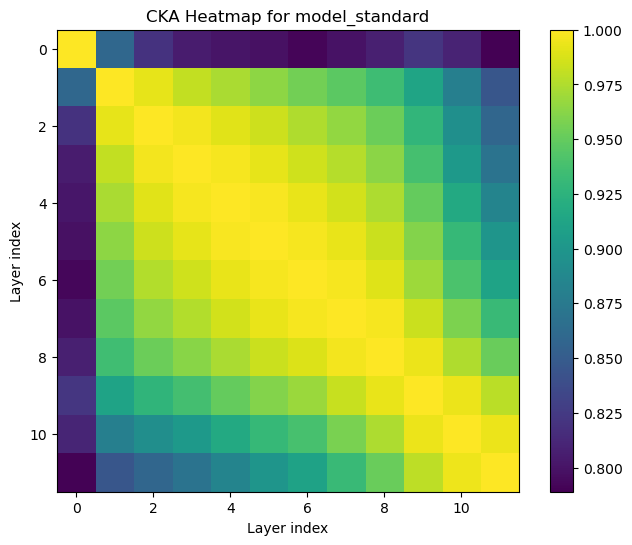

In [146]:
model_standard = "model_20250218_170429_bl12_ts1_bs128.pth"

###########################################
# CKA Calculation Functions
###########################################
def compute_linear_CKA(X, Y):
    """
    Computes linear CKA similarity between two activations.
    X and Y should be 2D tensors of shape (n_samples, n_features).
    """
    # Center the features.
    X_centered = X - X.mean(0, keepdim=True)
    Y_centered = Y - Y.mean(0, keepdim=True)
    dot_similarity = torch.norm(X_centered.T @ Y_centered, p='fro') ** 2
    normalization = torch.norm(X_centered.T @ X_centered, p='fro') * torch.norm(Y_centered.T @ Y_centered, p='fro')
    return (dot_similarity / (normalization + 1e-12)).item()

###########################################
# Hook and Global Activations
###########################################
activations = {}

def hook_fn(module, input, output, layer_name):
    """
    Hook function to capture activations.
    If the output is a scalar (0-dim), unsqueeze it.
    """
    if isinstance(output, torch.Tensor) and output.dim() == 0:
        output = output.unsqueeze(0)
    activations[layer_name] = output.detach()

def register_first_hooks(model):
    """
    Registers forward hooks on the first component of each block.
    The activation from the first component of each block is stored under "block_{i}_norm".
    """
    for idx, block in enumerate(model.blocks):
        first_component = block[0]
        first_component.register_forward_hook(lambda mod, inp, out, idx=idx: hook_fn(mod, inp, out, f"block_{idx}_norm"))

###########################################
# State Dict Helper: Remove Prefix
###########################################
def remove_prefix_from_state_dict(state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith(prefix):
            new_state_dict[key[len(prefix):]] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

###########################################
# Function to Load a Fixed Batch from CIFAR-10
###########################################
def load_fixed_batch(batch_size=100, root="./data/cifar-10-python", val_ratio=0.1, device="cpu"):
    """
    Loads the CIFAR-10 test set (with no augmentation) and returns the first batch as a fixed tensor.
    """
    _, _, testset, _ = get_cifar10_datasets(root=root, val_ratio=val_ratio)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for images, _ in test_loader:
            return images.to(device)
    return None

###########################################
# Model Loading Function
###########################################
def load_energy_transformer(checkpoint_path, device):
    """
    Instantiates the Energy Transformer model using a real CIFAR-10 test sample to determine input shape.
    Loads the given checkpoint (removing any '_orig_mod.' prefix if present) and returns the model.
    """
    fixed_batch = load_fixed_batch(batch_size=100, device=device)
    patch_fn = Patch(dim=4, n=32)
    model = ET(
        x=fixed_batch,
        patch=patch_fn,
        num_classes=10,
        tkn_dim=128,
        qk_dim=64,
        nheads=8,
        hn_mult=4.0,
        attn_beta=0.125,
        attn_bias=False,
        hn_bias=False,
        time_steps=1,
        blocks=12,    # Grouping is determined by filename.
    ).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    state_dict = remove_prefix_from_state_dict(state_dict, prefix="_orig_mod.")
    model.load_state_dict(state_dict)
    model.eval()
    return model

###########################################
# Compute CKA Matrix for a Single Model
###########################################
def compute_cka_matrix(checkpoint_path, device="cpu", fixed_batch=None):
    """
    Loads the model from the given checkpoint, registers hooks on the first component
    (EnergyLayerNorm) of each block, runs one forward pass using fixed_batch, and computes
    the CKA similarity matrix over these activations.
    Returns a numpy array of shape (num_blocks, num_blocks).
    """
    global activations
    activations = {}
    
    model = load_energy_transformer(checkpoint_path, device)
    register_first_hooks(model)
    
    if fixed_batch is None:
        fixed_batch = load_fixed_batch(device=device)
    
    with torch.no_grad():
        _ = model(fixed_batch)
    
    num_blocks = len(model.blocks)
    cka_matrix = np.zeros((num_blocks, num_blocks))
    for i in range(num_blocks):
        key_i = f"block_{i}_norm"
        act_i = activations[key_i]
        if act_i.dim() == 0:
            act_i = act_i.unsqueeze(0)
        act_i = act_i.view(act_i.size(0), -1)
        for j in range(num_blocks):
            key_j = f"block_{j}_norm"
            act_j = activations[key_j]
            if act_j.dim() == 0:
                act_j = act_j.unsqueeze(0)
            act_j = act_j.view(act_j.size(0), -1)
            cka_matrix[i, j] = compute_linear_CKA(act_i, act_j)
    return cka_matrix

###########################################
# Main Execution: Running CKA on model_standard
###########################################
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    fixed_batch = load_fixed_batch(device=device)
    
    # Compute the CKA matrix for the standard model
    cka_matrix = compute_cka_matrix(model_standard, device=device, fixed_batch=fixed_batch)
    
    # Plot the CKA heatmap for the model_standard
    plt.figure(figsize=(8, 6))
    plt.imshow(cka_matrix, interpolation="nearest", cmap="viridis")
    plt.title("CKA Heatmap for model_standard")
    plt.xlabel("Layer index")
    plt.ylabel("Layer index")
    plt.colorbar()
    save_filename = f"et_standard_cka_heatmap.pdf"
    plt.savefig(save_filename, format='pdf')
    plt.show()


# Centered Kernel Alignment Helpers

In [147]:
model_standard = "model_20250218_170429_bl12_ts1_bs128.pth"
checkpoint_paths = [
    "model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth",
    "model_20250218_181432_bl12_ts1_bs128_si5_ss1.pth",
    "model_20250218_191848_bl12_ts1_bs128_si2_ss1.pth",
    "model_20250218_202230_bl12_ts1_bs128_si1_ss1.pth",
    "model_20250218_212821_bl12_ts1_bs128_si10_ss2.pth",
    "model_20250218_223241_bl12_ts1_bs128_si5_ss2.pth",
    "model_20250218_233527_bl12_ts1_bs128_si2_ss2.pth",
    "model_20250219_003935_bl12_ts1_bs128_si1_ss2.pth",
    "model_20250219_014311_bl12_ts1_bs128_si10_ss3.pth",
    "model_20250219_024647_bl12_ts1_bs128_si5_ss3.pth",
    "model_20250219_035025_bl12_ts1_bs128_si2_ss3.pth",
    "model_20250219_045353_bl12_ts1_bs128_si1_ss3.pth",
    "model_20250219_055732_bl12_ts1_bs128_si10_ss4.pth",
    "model_20250219_070042_bl12_ts1_bs128_si5_ss4.pth",
    "model_20250219_080432_bl12_ts1_bs128_si2_ss4.pth",
    "model_20250219_090855_bl12_ts1_bs128_si1_ss4.pth",
   
]

###########################################
# CKA Calculation Functions
###########################################
def compute_linear_CKA(X, Y):
    """
    Computes linear CKA similarity between two activations.
    X and Y should be 2D tensors of shape (n_samples, n_features).
    """
    # Center the features.
    X_centered = X - X.mean(0, keepdim=True)
    Y_centered = Y - Y.mean(0, keepdim=True)
    dot_similarity = torch.norm(X_centered.T @ Y_centered, p='fro') ** 2
    normalization = torch.norm(X_centered.T @ X_centered, p='fro') * torch.norm(Y_centered.T @ Y_centered, p='fro')
    return (dot_similarity / (normalization + 1e-12)).item()

###########################################
# Hook and Global Activations
###########################################
# Global dictionary to store activations.
activations = {}

def hook_fn(module, input, output, layer_name):
    """
    Hook function to capture activations.
    If the output is a scalar (0-dim), unsqueeze it.
    """
    if isinstance(output, torch.Tensor) and output.dim() == 0:
        output = output.unsqueeze(0)
    activations[layer_name] = output.detach()

def register_first_hooks(model):
    """
    Registers forward hooks on the first component of each block.
    The activation from the first component of each block is stored under "block_{i}_norm".
    """
    for idx, block in enumerate(model.blocks):
        first_component = block[0]
        first_component.register_forward_hook(lambda mod, inp, out, idx=idx: hook_fn(mod, inp, out, f"block_{idx}_norm"))

###########################################
# State Dict Helper: Remove Prefix
###########################################
def remove_prefix_from_state_dict(state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith(prefix):
            new_state_dict[key[len(prefix):]] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

###########################################
# Function to Load a Fixed Batch from CIFAR-10
###########################################
def load_fixed_batch(batch_size=100, root="./data/cifar-10-python", val_ratio=0.1, device="cpu"):
    """
    Loads the CIFAR-10 test set (with no augmentation) and returns the first batch as a fixed tensor.
    """
    _, _, testset, _ = get_cifar10_datasets(root=root, val_ratio=val_ratio)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for images, _ in test_loader:
            return images.to(device)
    return None

###########################################
# Model Loading Function
###########################################
def load_energy_transformer(checkpoint_path, device):
    """
    Instantiates the Energy Transformer model using a real CIFAR-10 test sample to determine input shape.
    Loads the given checkpoint (removing any '_orig_mod.' prefix if present) and returns the model.
    """
    fixed_batch = load_fixed_batch(batch_size=100, device=device)
    patch_fn = Patch(dim=4, n=32)
    model = ET(
        x=fixed_batch,
        patch=patch_fn,
        num_classes=10,
        tkn_dim=128,
        qk_dim=64,
        nheads=8,
        hn_mult=4.0,
        attn_beta=0.125,
        attn_bias=False,
        hn_bias=False,
        time_steps=1,
        blocks=12,    # Grouping is determined by filename.
    ).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    state_dict = remove_prefix_from_state_dict(state_dict, prefix="_orig_mod.")
    model.load_state_dict(state_dict)
    model.eval()
    return model

###########################################
# Compute CKA Matrix for a Single Model
###########################################
def compute_cka_matrix(checkpoint_path, device="cpu", fixed_batch=None):
    """
    Loads the model from the given checkpoint, registers hooks on the first component
    (EnergyLayerNorm) of each block, runs one forward pass using fixed_batch, and computes
    the CKA similarity matrix over these activations.
    Returns a numpy array of shape (num_blocks, num_blocks).
    """
    global activations
    activations = {}
    
    model = load_energy_transformer(checkpoint_path, device)
    register_first_hooks(model)
    
    if fixed_batch is None:
        fixed_batch = load_fixed_batch(device=device)
    
    with torch.no_grad():
        _ = model(fixed_batch)
    
    num_blocks = len(model.blocks)
    cka_matrix = np.zeros((num_blocks, num_blocks))
    for i in range(num_blocks):
        key_i = f"block_{i}_norm"
        act_i = activations[key_i]
        if act_i.dim() == 0:
            act_i = act_i.unsqueeze(0)
        act_i = act_i.view(act_i.size(0), -1)
        for j in range(num_blocks):
            key_j = f"block_{j}_norm"
            act_j = activations[key_j]
            if act_j.dim() == 0:
                act_j = act_j.unsqueeze(0)
            act_j = act_j.view(act_j.size(0), -1)
            cka_matrix[i, j] = compute_linear_CKA(act_i, act_j)
    return cka_matrix

###########################################
# Function to Compute All CKA Matrices (Dictionary)
###########################################
def compute_cka_matrices_dict(checkpoint_paths, device="cpu", fixed_batch=None):
    """
    Computes the CKA matrix for each checkpoint in checkpoint_paths.
    Returns a dictionary mapping each swapping strategy (ss as an integer)
    to a list of tuples: (swapping_interval, cka_matrix, title).
    The title is generated as: "ss={ss_value}, si={si}".
    """
    ss_pattern = re.compile(r'ss(\d+)')
    si_pattern = re.compile(r'si([\d\.]+)')
    cka_dict = {}
    if fixed_batch is None:
        fixed_batch = load_fixed_batch(device=device)
    for cp in checkpoint_paths:
        ss_match = ss_pattern.search(cp)
        if ss_match:
            ss_val = int(ss_match.group(1))
            si_match = si_pattern.search(cp)
            si_val = float(si_match.group(1)) if si_match else np.inf
            print(f"Computing CKA for checkpoint: {cp} (SS={ss_val}, SI={si_val})")
            matrix = compute_cka_matrix(cp, device, fixed_batch=fixed_batch)
            # New title format:
            title = f"ss={ss_val}, si={int(si_val) if si_val.is_integer() else si_val}"
            if ss_val not in cka_dict:
                cka_dict[ss_val] = []
            cka_dict[ss_val].append((si_val, matrix, title))
    # Sort each group's list by swapping interval.
    for ss_val in cka_dict:
        cka_dict[ss_val].sort(key=lambda x: x[0])
    return cka_dict

###########################################
# Plotting Function for a List of CKA Matrices
###########################################
def plot_cka_matrices(cka_matrices, titles, vmin, vmax, ss_value):
    """
    Plots a 2x3 grid of CKA heatmaps using the provided list of matrices.
    All heatmaps share the same color scale (vmin, vmax).
    The titles list provides a title for each subplot.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx in range(6):
        if idx < len(cka_matrices):
            im = axes[idx].imshow(cka_matrices[idx], interpolation="nearest", cmap="viridis", vmin=vmin, vmax=vmax)
            axes[idx].set_title(titles[idx])
            axes[idx].set_xlabel("Layer index")
            axes[idx].set_ylabel("Layer index")
            fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
        else:
            axes[idx].axis("off")
    
    plt.suptitle(f"CKA Heatmaps for Swapped Models (ss={ss_value})", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_filename = f"et_ss{ss_value}_cka_heatmap.pdf"
    plt.savefig(save_filename, format='pdf')
    plt.show()

###########################################
# Final Plot Function: plot_cka_heatmap_by_ss
###########################################
def plot_cka_heatmap_by_ss(ss_value, cka_dict, global_vmin=None, global_vmax=None):
    """
    For a given swapping strategy (ss_value), extract the list of computed CKA matrices
    from the provided dictionary, compute the global color scale (if not provided), and plot
    up to 6 heatmaps in a 2x3 grid using that global color scale.
    """
    if ss_value not in cka_dict or len(cka_dict[ss_value]) == 0:
        print(f"No CKA matrices found for ss = {ss_value}")
        return
    
    # Extract matrices and titles for the selected swapping strategy.
    # Select up to 6 checkpoints to capture both the original and the new si values.
    selected = cka_dict[ss_value][:6]
    matrices = [item[1] for item in selected]
    titles = [item[2] for item in selected]
    
    # Compute overall global min and max if not provided.
    if global_vmin is None or global_vmax is None:
        all_matrices = []
        for group in cka_dict.values():
            for (_, m, _) in group:
                all_matrices.append(m)
        global_vmin = min(m.min() for m in all_matrices)
        global_vmax = max(m.max() for m in all_matrices)
    
    plot_cka_matrices(matrices, titles, vmin=global_vmin, vmax=global_vmax, ss_value=ss_value)

In [148]:
cka_dict = compute_cka_matrices_dict(checkpoint_paths, device="mps")

Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth (SS=1, SI=10.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_181432_bl12_ts1_bs128_si5_ss1.pth (SS=1, SI=5.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_191848_bl12_ts1_bs128_si2_ss1.pth (SS=1, SI=2.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_202230_bl12_ts1_bs128_si1_ss1.pth (SS=1, SI=1.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_212821_bl12_ts1_bs128_si10_ss2.pth (SS=2, SI=10.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_223241_bl12_ts1_bs128_si5

In [150]:
###########################################
# Plotting Function for a List of CKA Matrices
###########################################
def plot_cka_matrices(cka_matrices, titles, vmin, vmax, ss_value):
    """
    Plots a 2x2 grid of CKA heatmaps using the provided list of matrices.
    All heatmaps share the same color scale (vmin, vmax).
    The titles list provides a title for each subplot.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx in range(4):
        if idx < len(cka_matrices):
            im = axes[idx].imshow(cka_matrices[idx], interpolation="nearest", cmap="viridis", vmin=vmin, vmax=vmax)
            axes[idx].set_title(titles[idx])
            axes[idx].set_xlabel("Layer index")
            axes[idx].set_ylabel("Layer index")
            fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
        else:
            axes[idx].axis("off")
    
    plt.suptitle(f"CKA Heatmaps for Swapped Models (ss={ss_value})", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_filename = f"et_ss{ss_value}_cka_heatmap.pdf"
    plt.savefig(save_filename, format='pdf')
    plt.show()

###########################################
# Final Plot Function: plot_cka_heatmap_by_ss
###########################################
def plot_cka_heatmap_by_ss(ss_value, cka_dict, global_vmin=None, global_vmax=None):
    """
    For a given swapping strategy (ss_value), extract the list of computed CKA matrices
    from the provided dictionary, compute the global color scale (if not provided), and plot
    up to 4 heatmaps in a 2x2 grid using that global color scale.
    """
    if ss_value not in cka_dict or len(cka_dict[ss_value]) == 0:
        print(f"No CKA matrices found for ss = {ss_value}")
        return
    
    # Extract matrices and titles for the selected swapping strategy.
    # Select up to 4 checkpoints to capture both the original and the new si values.
    selected = cka_dict[ss_value][:4]
    matrices = [item[1] for item in selected]
    titles = [item[2] for item in selected]
    
    # Compute overall global min and max if not provided.
    if global_vmin is None or global_vmax is None:
        all_matrices = []
        for group in cka_dict.values():
            for (_, m, _) in group:
                all_matrices.append(m)
        global_vmin = min(m.min() for m in all_matrices)
        global_vmax = max(m.max() for m in all_matrices)
    
    plot_cka_matrices(matrices, titles, vmin=global_vmin, vmax=global_vmax, ss_value=ss_value)


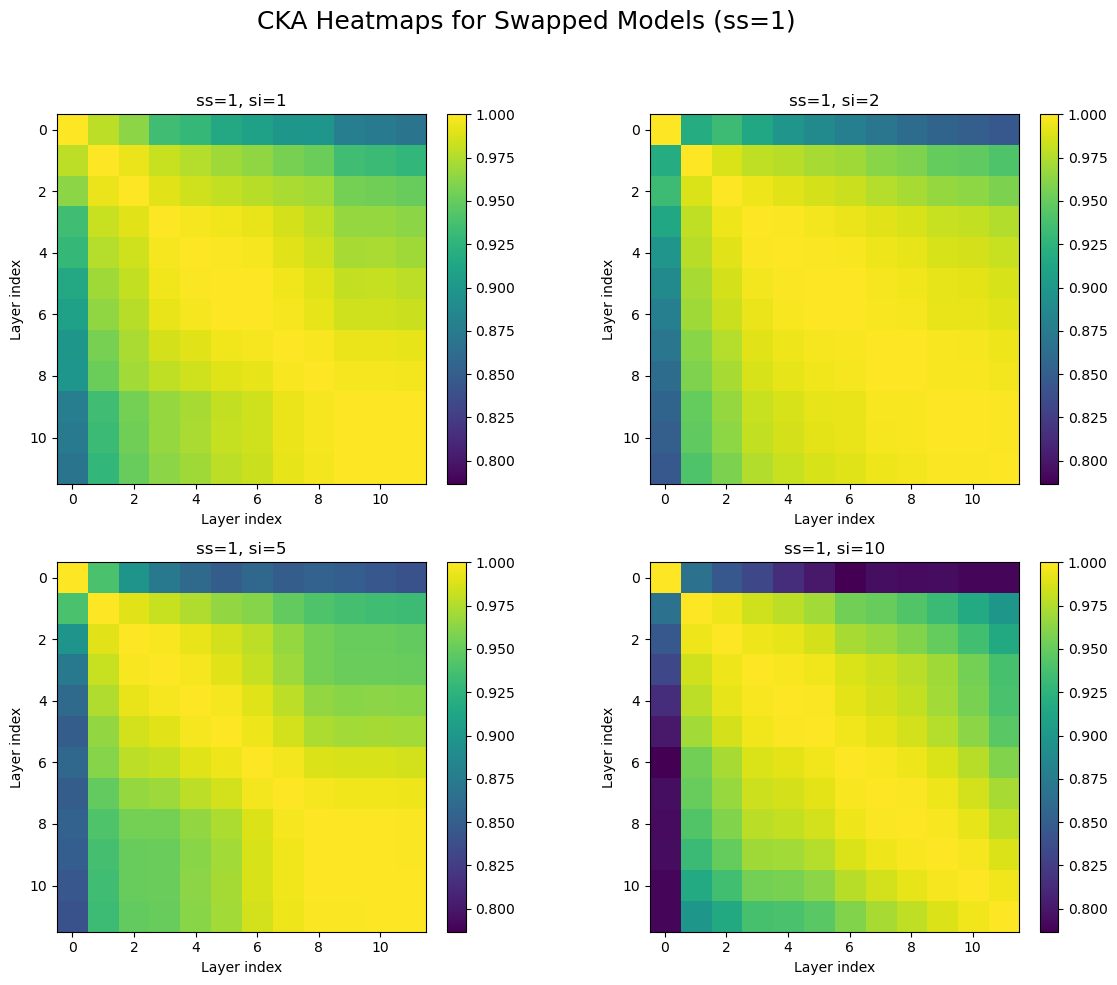

In [151]:
plot_cka_heatmap_by_ss(ss_value=1, cka_dict=cka_dict)

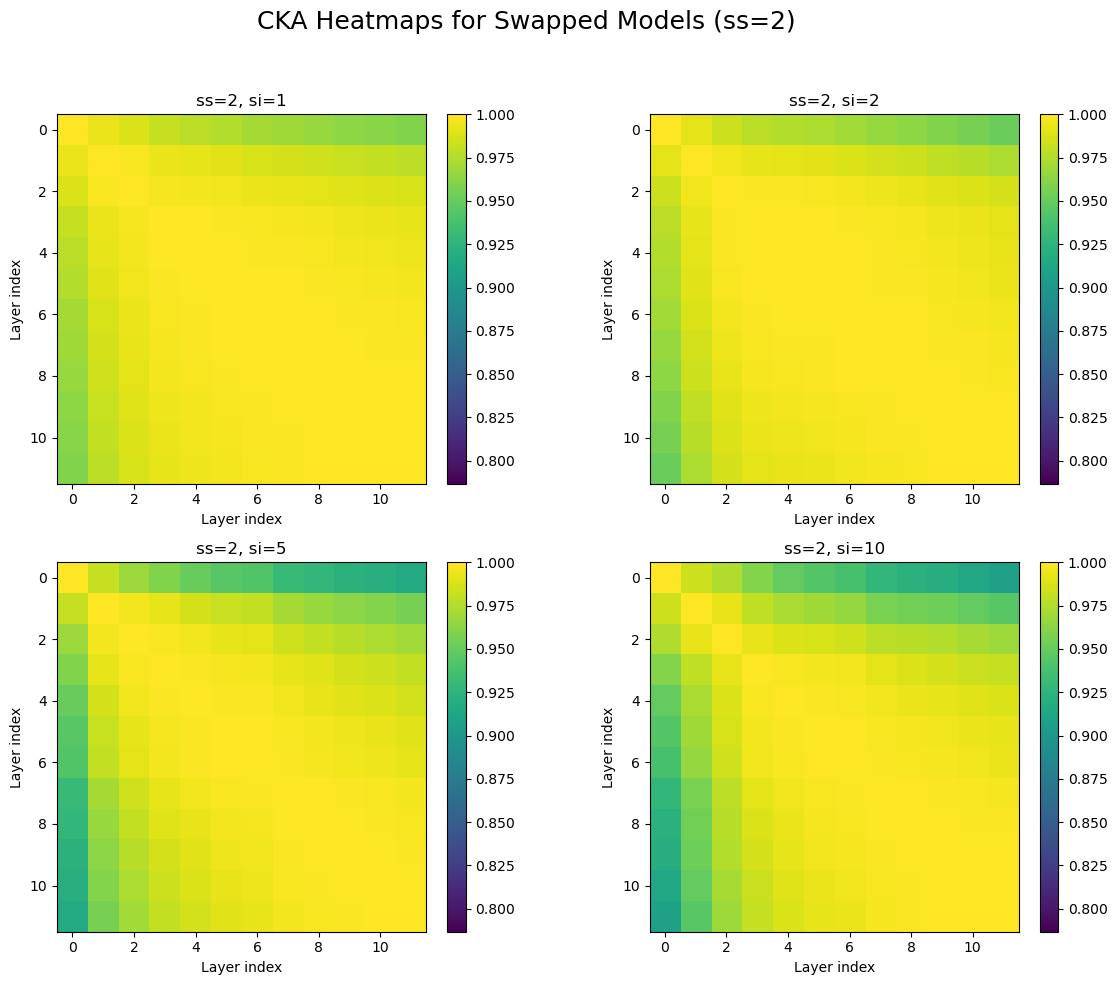

In [152]:
plot_cka_heatmap_by_ss(ss_value=2, cka_dict=cka_dict)

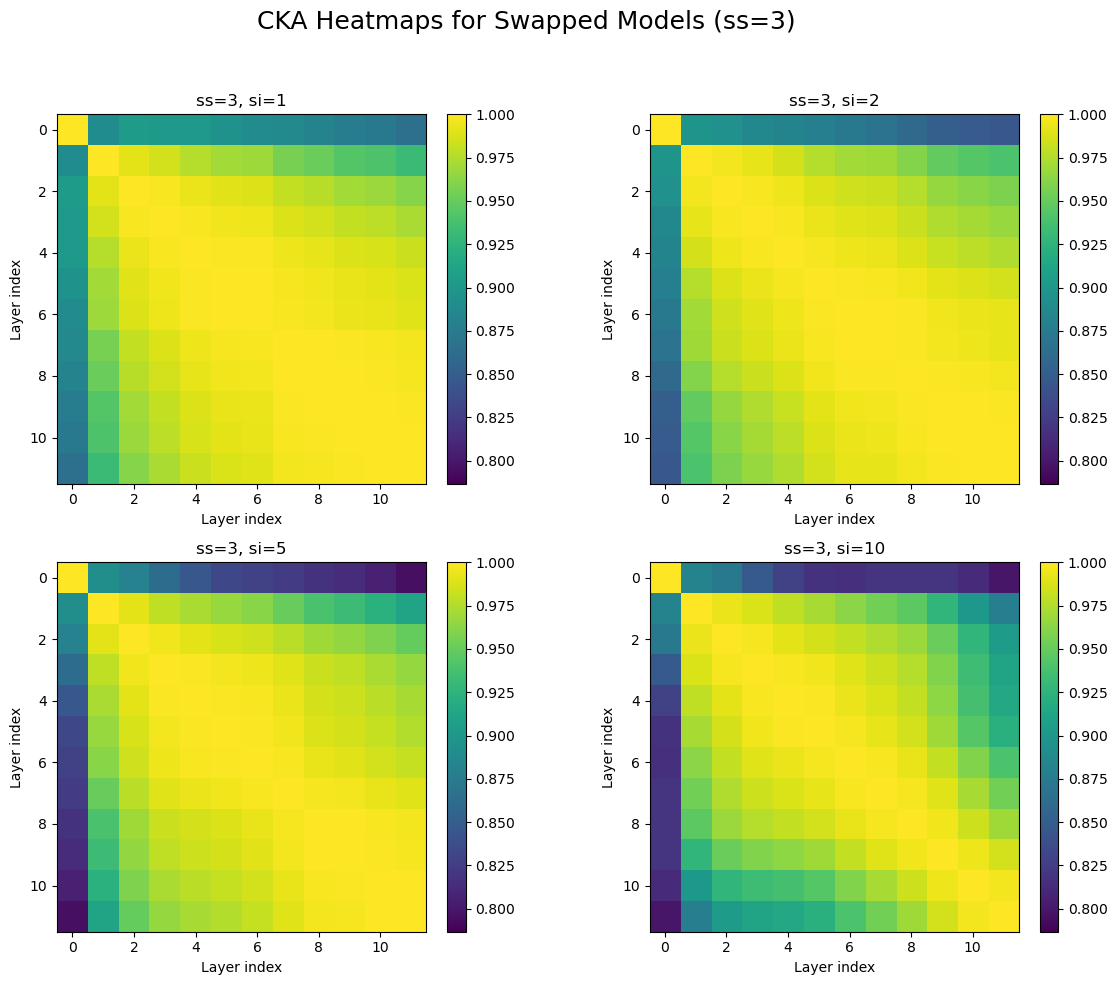

In [153]:
plot_cka_heatmap_by_ss(ss_value=3, cka_dict=cka_dict)

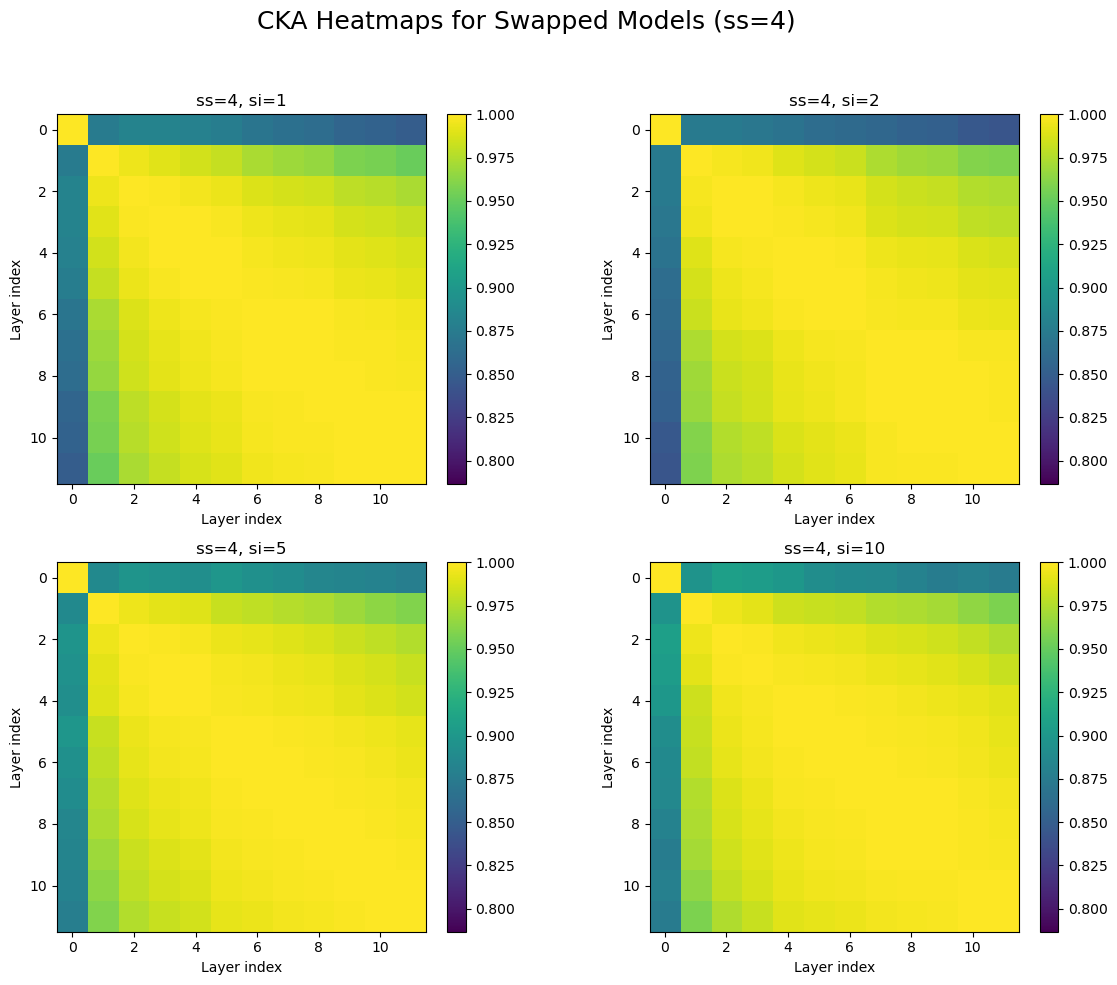

In [154]:
plot_cka_heatmap_by_ss(ss_value=4, cka_dict=cka_dict)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from image_et.core import ET, Patch
from image_et.utils import get_cifar10_datasets  # your updated CIFAR-10 loader
from torch.utils.data import DataLoader, default_collate

###########################################
# CKA Calculation Function
###########################################
def compute_linear_CKA(X, Y):
    """
    Computes linear CKA similarity between two activations.
    X and Y should be 2D tensors of shape (n_samples, n_features).
    """
    # Center the features
    X_centered = X - X.mean(0, keepdim=True)
    Y_centered = Y - Y.mean(0, keepdim=True)
    dot_similarity = torch.norm(X_centered.T @ Y_centered, p='fro') ** 2
    normalization = torch.norm(X_centered.T @ X_centered, p='fro') * torch.norm(Y_centered.T @ Y_centered, p='fro')
    return (dot_similarity / (normalization + 1e-12)).item()

###########################################
# State Dict Helper
###########################################
def remove_prefix_from_state_dict(state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith(prefix):
            new_state_dict[key[len(prefix):]] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

###########################################
# Model Loading Function
###########################################
def load_energy_transformer(checkpoint_path, device):
    """
    Instantiates the Energy Transformer model with fixed parameters,
    loads the given checkpoint (removing the '_orig_mod.' prefix if necessary),
    and returns the model on the specified device.
    """
    patch_fn = Patch(dim=4, n=32)
    dummy_input = torch.randn(1, 3, 32, 32)
    model = ET(
        x=dummy_input,
        patch=patch_fn,
        num_classes=10,
        tkn_dim=128,
        qk_dim=64,
        nheads=8,
        hn_mult=4.0,
        attn_beta=0.125,
        attn_bias=False,
        hn_bias=False,
        time_steps=1,
        blocks=12,
        swap_interval=10,   # Adjust as needed
        swap_strategy=1     # Adjust as needed
    ).to(device)
    
    state_dict = torch.load(checkpoint_path, map_location=device)
    state_dict = remove_prefix_from_state_dict(state_dict, prefix="_orig_mod.")
    model.load_state_dict(state_dict)
    model.eval()
    return model

###########################################
# Monkey-Patch Attention Forward
###########################################
def new_attention_forward(self, g, mask=None):
    """
    Modified forward method for the Attention module that stores the
    intermediate attention scores (A) before applying the final reduction.
    """
    q = torch.einsum("...kd,...hzd->...khz", g, self.wq)
    k = torch.einsum("...kd,...hzd->...khz", g, self.wk)
    if self.bq is not None:
        q += self.bq
        k += self.bk
    A = torch.einsum("...qhz,...khz->...hqk", q, k)
    if mask is not None:
        A *= mask
    # Store the attention activation for analysis.
    self.attn_activation = A.detach()
    # Return the final output (as in the original implementation).
    return (-1.0 / self.beta) * torch.logsumexp(self.beta * A, dim=-1).sum()

def patch_attention_modules(model):
    """
    Monkey-patches every attention module in the Energy Transformer blocks
    so that they store their intermediate activation (A) in an attribute.
    """
    for block in model.blocks:
        attn_module = block[1].attn
        attn_module.forward = new_attention_forward.__get__(attn_module, type(attn_module))

###########################################
# Main CKA Analysis Function
###########################################
def run_attention_cka_analysis(checkpoint_path, device="cpu"):
    # Load model from checkpoint.
    model = load_energy_transformer(checkpoint_path, device)
    # Patch the attention modules.
    patch_attention_modules(model)
    
    # Load CIFAR-10 test set (no augmentation).
    _, _, testset, _ = get_cifar10_datasets(root="./data/cifar-10-python", val_ratio=0.1)
    test_loader = DataLoader(testset, batch_size=100, shuffle=False, collate_fn=lambda batch: default_collate(batch))
    
    # Run one forward pass on a single test batch to collect attention activations.
    with torch.no_grad():
        for images, _ in test_loader:
            _ = model(images.to(device))
            break
    
    # Collect attention activations from each block.
    num_layers = len(model.blocks)
    attn_activations = {}
    for idx, block in enumerate(model.blocks):
        # We assume that after the forward pass, each attention module has stored
        # its intermediate activation in `attn_activation`.
        attn_activations[f"block_{idx}_attn"] = block[1].attn.attn_activation
    
    # Compute CKA similarity matrix over the attention activations.
    cka_matrix = np.zeros((num_layers, num_layers))
    for i in range(num_layers):
        for j in range(num_layers):
            act_i = attn_activations[f"block_{i}_attn"].view(attn_activations[f"block_{i}_attn"].size(0), -1)
            act_j = attn_activations[f"block_{j}_attn"].view(attn_activations[f"block_{j}_attn"].size(0), -1)
            cka_matrix[i, j] = compute_linear_CKA(act_i, act_j)
    
    # Plot the CKA heatmap.
    plt.figure(figsize=(8, 6))
    plt.imshow(cka_matrix, interpolation="nearest", cmap="viridis")
    plt.title("CKA Similarity between Attention Activations in Energy Transformer Blocks")
    plt.xlabel("Block index")
    plt.ylabel("Block index")
    plt.colorbar(label="CKA value")
    plt.show()

# Run the analysis in your Jupyter Notebook cell:
checkpoint_path = "model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth"  # Update if needed
device = "mps" if torch.cuda.is_available() else "cpu"
run_attention_cka_analysis(checkpoint_path, device)


/var/folders/7c/zq5pjc5156v6v5k591lqrbgc0000gp/T/ipykernel_16633/384616328.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_

Files already downloaded and verified
Files already downloaded and verified


In [88]:
import torch

# Load the state dictionary from the .pth file
state_dict = torch.load("model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth", map_location='cpu', weights_only = True)

# Print all keys in the state dictionary

for k, v in state_dict.items():
        print(f"  {k}: shape {v.shape}, norm {v.norm():.4f}")

  _orig_mod.cls: shape torch.Size([1, 1, 128]), norm 12.0323
  _orig_mod.encode.0.weight: shape torch.Size([128, 48]), norm 6.5416
  _orig_mod.encode.0.bias: shape torch.Size([128]), norm 0.8604
  _orig_mod.decode.0.gamma: shape torch.Size([1]), norm 1.0022
  _orig_mod.decode.0.bias: shape torch.Size([128]), norm 0.0824
  _orig_mod.decode.1.weight: shape torch.Size([10, 128]), norm 1.8679
  _orig_mod.decode.1.bias: shape torch.Size([10]), norm 0.1814
  _orig_mod.pos.weight: shape torch.Size([1, 65, 128]), norm 5.1431
  _orig_mod.blocks.0.0.gamma: shape torch.Size([1]), norm 0.8483
  _orig_mod.blocks.0.0.bias: shape torch.Size([128]), norm 0.1853
  _orig_mod.blocks.0.1.hn.proj.weight: shape torch.Size([512, 128]), norm 14.2289
  _orig_mod.blocks.0.1.attn.wq: shape torch.Size([8, 64, 128]), norm 5.0821
  _orig_mod.blocks.0.1.attn.wk: shape torch.Size([8, 64, 128]), norm 5.1311
  _orig_mod.blocks.1.0.gamma: shape torch.Size([1]), norm 1.1506
  _orig_mod.blocks.1.0.bias: shape torch.Size([

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from einops import rearrange
from typing import Callable, Optional, Union, Sequence

###########################################
# Model Components
###########################################
TENSOR = torch.Tensor

class Lambda(nn.Module):
    def __init__(self, fn: Callable):
        super().__init__()
        self.fn = fn

    def forward(self, x: TENSOR):
        return self.fn(x)

class Patch(nn.Module):
    def __init__(self, dim: int = 4, n: int = 32):
        super().__init__()
        self.transform = Lambda(
            lambda x: rearrange(x, "... c (h p1) (w p2) -> ... (h w) (c p1 p2)", p1=dim, p2=dim)
        )
        r = n // dim
        self.N = r ** 2
        self.revert = Lambda(
            lambda x: rearrange(
                x, "... (h w) (c p1 p2) -> ... c (h p1) (w p2)",
                h=r, w=r, p1=dim, p2=dim
            )
        )

    def forward(self, x: TENSOR, reverse: bool = False):
        return self.revert(x) if reverse else self.transform(x)

class EnergyLayerNorm(nn.Module):
    def __init__(self, in_dim: int, bias: bool = True, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(in_dim)) if bias else 0.0

    def forward(self, x: TENSOR):
        xu = x.mean(-1, keepdim=True)
        xm = x - xu
        o = xm / torch.sqrt((xm ** 2.0).mean(-1, keepdim=True) + self.eps)
        return self.gamma * o + self.bias

class PositionEncode(nn.Module):
    def __init__(self, dim: int, n: int):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, n, dim) * 0.02)

    def forward(self, x: TENSOR):
        return x + self.weight

class Hopfield(nn.Module):
    def __init__(self, in_dim: int, multiplier: float = 4.0, bias: bool = False):
        super().__init__()
        self.proj = nn.Linear(in_dim, int(in_dim * multiplier), bias=bias)

    def forward(self, g: TENSOR):
        return -0.5 * (F.relu(self.proj(g)) ** 2).sum()

class Attention(nn.Module):
    def __init__(self, in_dim: int, qk_dim: int = 64, nheads: int = 12, beta: float = None, bias: bool = False):
        super().__init__()
        self.h, self.d = nheads, qk_dim
        self.beta = beta or 1.0 / (qk_dim ** 0.5)
        self.wq = nn.Parameter(torch.randn(nheads, qk_dim, in_dim) * 0.02)
        self.wk = nn.Parameter(torch.randn(nheads, qk_dim, in_dim) * 0.02)
        self.bq = nn.Parameter(torch.zeros(qk_dim)) if bias else None
        self.bk = nn.Parameter(torch.zeros(qk_dim)) if bias else None

    def forward(self, g: TENSOR, mask: TENSOR = None):
        q = torch.einsum("...kd,...hzd->...khz", g, self.wq)
        k = torch.einsum("...kd,...hzd->...khz", g, self.wk)
        if self.bq is not None:
            q += self.bq
            k += self.bk
        A = torch.einsum("...qhz,...khz->...hqk", q, k)
        if mask is not None:
            A *= mask
        return (-1.0 / self.beta) * torch.logsumexp(self.beta * A, dim=-1).sum()

class ETBlock(nn.Module):
    def __init__(self, in_dim: int, qk_dim: int = 64, nheads: int = 12, 
                 hn_mult: float = 4.0, attn_beta: float = None, 
                 attn_bias: bool = False, hn_bias: bool = False):
        super().__init__()
        self.hn = Hopfield(in_dim, hn_mult, hn_bias)
        self.attn = Attention(in_dim, qk_dim, nheads, attn_beta, attn_bias)

    def energy(self, g: TENSOR, mask: TENSOR = None):
        return self.attn(g, mask) + self.hn(g)

    def forward(self, g: TENSOR, mask: TENSOR = None):
        return self.energy(g, mask)

class ET(nn.Module):
    def __init__(self, x: TENSOR, patch: nn.Module, num_classes: int,
                 tkn_dim: int = 128, qk_dim: int = 64, nheads: int = 8,
                 hn_mult: float = 4.0, attn_beta: float = None,
                 attn_bias: bool = False, hn_bias: bool = False,
                 time_steps: int = 1, blocks: int = 12):
        super().__init__()
        x = patch(x)
        _, n, d = x.shape
        
        self.patch = patch
        self.encode = nn.Sequential(nn.Linear(d, tkn_dim))
        self.decode = nn.Sequential(
            EnergyLayerNorm(tkn_dim),
            nn.Linear(tkn_dim, num_classes)
        )
        self.pos = PositionEncode(tkn_dim, n + 1)
        self.cls = nn.Parameter(torch.randn(1, 1, tkn_dim))
        self.blocks = nn.ModuleList([
            nn.ModuleList([
                EnergyLayerNorm(tkn_dim),
                ETBlock(tkn_dim, qk_dim, nheads, hn_mult, attn_beta, attn_bias, hn_bias)
            ]) for _ in range(blocks)
        ])
        self.K = time_steps

    def forward(self, x: TENSOR, alpha: float = 1.0):
        x = self.patch(x)
        x = self.encode(x)
        x = torch.cat([self.cls.expand(x.size(0), -1, -1), x], dim=1)
        x = self.pos(x)
        
        for norm, et in self.blocks:
            for _ in range(self.K):
                g = norm(x)
                dEdg, E = torch.func.grad_and_value(et)(g)
                x = x - alpha * dEdg
        
        x = self.decode(x[:, 0])  # CLS token classification
        return x

###########################################
# Helper Functions
###########################################
def compute_linear_CKA(X, Y):
    """
    Computes linear CKA similarity between two activations.
    X and Y should be 2D tensors of shape (n_samples, n_features).
    """
    # Center the features.
    X_centered = X - X.mean(0, keepdim=True)
    Y_centered = Y - Y.mean(0, keepdim=True)
    dot_similarity = torch.norm(X_centered.T @ Y_centered, p='fro') ** 2
    normalization = torch.norm(X_centered.T @ X_centered, p='fro') * torch.norm(Y_centered.T @ Y_centered, p='fro')
    return (dot_similarity / (normalization + 1e-12)).item()

def remove_prefix_from_state_dict(state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith(prefix):
            new_state_dict[key[len(prefix):]] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

def load_fixed_batch(batch_size=100, root="./data/cifar-10-python", val_ratio=0.1, device="cpu"):
    """
    Loads the CIFAR-10 test set (with no augmentation) and returns the first batch as a fixed tensor.
    Note: Assumes that get_cifar10_datasets is defined elsewhere.
    """
    _, _, testset, _ = get_cifar10_datasets(root=root, val_ratio=val_ratio)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for images, _ in test_loader:
            return images.to(device)
    return None

def load_energy_transformer(checkpoint_path, device):
    """
    Instantiates the Energy Transformer model using a real CIFAR-10 test sample to determine input shape.
    Loads the given checkpoint (removing any '_orig_mod.' prefix if present) and returns the model.
    """
    fixed_batch = load_fixed_batch(batch_size=100, device=device)
    patch_fn = Patch(dim=4, n=32)
    model = ET(
        x=fixed_batch,
        patch=patch_fn,
        num_classes=10,
        tkn_dim=128,
        qk_dim=64,
        nheads=8,
        hn_mult=4.0,
        attn_beta=0.125,
        attn_bias=False,
        hn_bias=False,
        time_steps=1,
        blocks=12  # Adjust number of blocks as needed.
    ).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    state_dict = remove_prefix_from_state_dict(state_dict, prefix="_orig_mod.")
    model.load_state_dict(state_dict)
    model.eval()
    return model

###########################################
# New CKA Computation for Last Component Activations
###########################################
def compute_cka_matrix_last(checkpoint_path, device="cpu", fixed_batch=None, alpha=1.0):
    """
    Loads the model from the given checkpoint and computes a CKA matrix over the 
    "last component" activations of each block. Here we capture the gradient 
    (dEdg) computed in each block via torch.func.grad_and_value on the ETBlock.
    """
    global activations_last
    activations_last = {}
    
    model = load_energy_transformer(checkpoint_path, device)
    
    if fixed_batch is None:
        fixed_batch = load_fixed_batch(device=device)
    
    # Preprocess input as in the forward pass.
    x = fixed_batch
    x = model.patch(x)
    x = model.encode(x)
    x = torch.cat([model.cls.expand(x.size(0), -1, -1), x], dim=1)
    x = model.pos(x)
    
    # For each block, compute the gradient dEdg from the ETBlock and store it.
    for i, (norm, et) in enumerate(model.blocks):
        for _ in range(model.K):
            g = norm(x)
            dEdg, E = torch.func.grad_and_value(et)(g)
            activations_last[f"block_{i}_last"] = dEdg.detach()
            x = x - alpha * dEdg

    num_blocks = len(model.blocks)
    cka_matrix = np.zeros((num_blocks, num_blocks))
    for i in range(num_blocks):
        key_i = f"block_{i}_last"
        act_i = activations_last[key_i]
        if act_i.dim() == 0:
            act_i = act_i.unsqueeze(0)
        act_i = act_i.view(act_i.size(0), -1)
        for j in range(num_blocks):
            key_j = f"block_{j}_last"
            act_j = activations_last[key_j]
            if act_j.dim() == 0:
                act_j = act_j.unsqueeze(0)
            act_j = act_j.view(act_j.size(0), -1)
            cka_matrix[i, j] = compute_linear_CKA(act_i, act_j)
    
    return cka_matrix

def compute_cka_matrices_dict_last(checkpoint_paths, device="cpu", fixed_batch=None, alpha=1.0):
    """
    Computes the last-component CKA matrix for each checkpoint in checkpoint_paths.
    Returns a dictionary mapping each swapping strategy (ss) to a list of tuples:
    (swapping_interval, cka_matrix, title).
    """
    ss_pattern = re.compile(r'ss(\d+)')
    si_pattern = re.compile(r'si([\d\.]+)')
    cka_dict = {}
    if fixed_batch is None:
        fixed_batch = load_fixed_batch(device=device)
    for cp in checkpoint_paths:
        ss_match = ss_pattern.search(cp)
        if ss_match:
            ss_val = int(ss_match.group(1))
            si_match = si_pattern.search(cp)
            si_val = float(si_match.group(1)) if si_match else np.inf
            print(f"Computing CKA for checkpoint: {cp} (SS={ss_val}, SI={si_val})")
            matrix = compute_cka_matrix_last(cp, device, fixed_batch=fixed_batch, alpha=alpha)
            title = f"ss={ss_val}, si={int(si_val) if si_val.is_integer() else si_val}"
            if ss_val not in cka_dict:
                cka_dict[ss_val] = []
            cka_dict[ss_val].append((si_val, matrix, title))
    # Sort each group's list by swapping interval.
    for ss_val in cka_dict:
        cka_dict[ss_val].sort(key=lambda x: x[0])
    return cka_dict

###########################################
# Plotting Functions
###########################################
def plot_cka_matrices(cka_matrices, titles, vmin, vmax, ss_value):
    """
    Plots a 2x2 grid of CKA heatmaps using the provided list of matrices.
    All heatmaps share the same color scale.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx in range(4):
        if idx < len(cka_matrices):
            im = axes[idx].imshow(cka_matrices[idx], interpolation="nearest", cmap="viridis", vmin=vmin, vmax=vmax)
            axes[idx].set_title(titles[idx])
            axes[idx].set_xlabel("Layer index")
            axes[idx].set_ylabel("Layer index")
            fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
        else:
            axes[idx].axis("off")
    
    plt.suptitle(f"CKA Heatmaps for Last Component Activations (ss={ss_value})", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_filename = f"et_ss{ss_value}_cka_heatmap_grad.pdf"
    plt.savefig(save_filename, format='pdf')
    plt.show()

def plot_cka_heatmap_by_ss(ss_value, cka_dict, global_vmin=None, global_vmax=None):
    """
    For a given swapping strategy (ss_value), extracts up to 4 computed CKA matrices
    from cka_dict, computes the overall color scale if not provided, and plots them.
    """
    if ss_value not in cka_dict or len(cka_dict[ss_value]) == 0:
        print(f"No CKA matrices found for ss = {ss_value}")
        return
    
    selected = cka_dict[ss_value][:4]
    matrices = [item[1] for item in selected]
    titles = [item[2] for item in selected]
    
    if global_vmin is None or global_vmax is None:
        all_matrices = []
        for group in cka_dict.values():
            for (_, m, _) in group:
                all_matrices.append(m)
        global_vmin = min(m.min() for m in all_matrices)
        global_vmax = max(m.max() for m in all_matrices)
        #print(f"Overall global min: {global_vmin:.3f}, global max: {global_vmax:.3f}")
    
    plot_cka_matrices(matrices, titles, vmin=global_vmin, vmax=global_vmax, ss_value=ss_value)




Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth (SS=1, SI=10.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_181432_bl12_ts1_bs128_si5_ss1.pth (SS=1, SI=5.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_191848_bl12_ts1_bs128_si2_ss1.pth (SS=1, SI=2.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_202230_bl12_ts1_bs128_si1_ss1.pth (SS=1, SI=1.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_212821_bl12_ts1_bs128_si10_ss2.pth (SS=2, SI=10.0)
Files already downloaded and verified
Files already downloaded and verified
Computing CKA for checkpoint: model_20250218_223241_bl12_ts1_bs128_si5

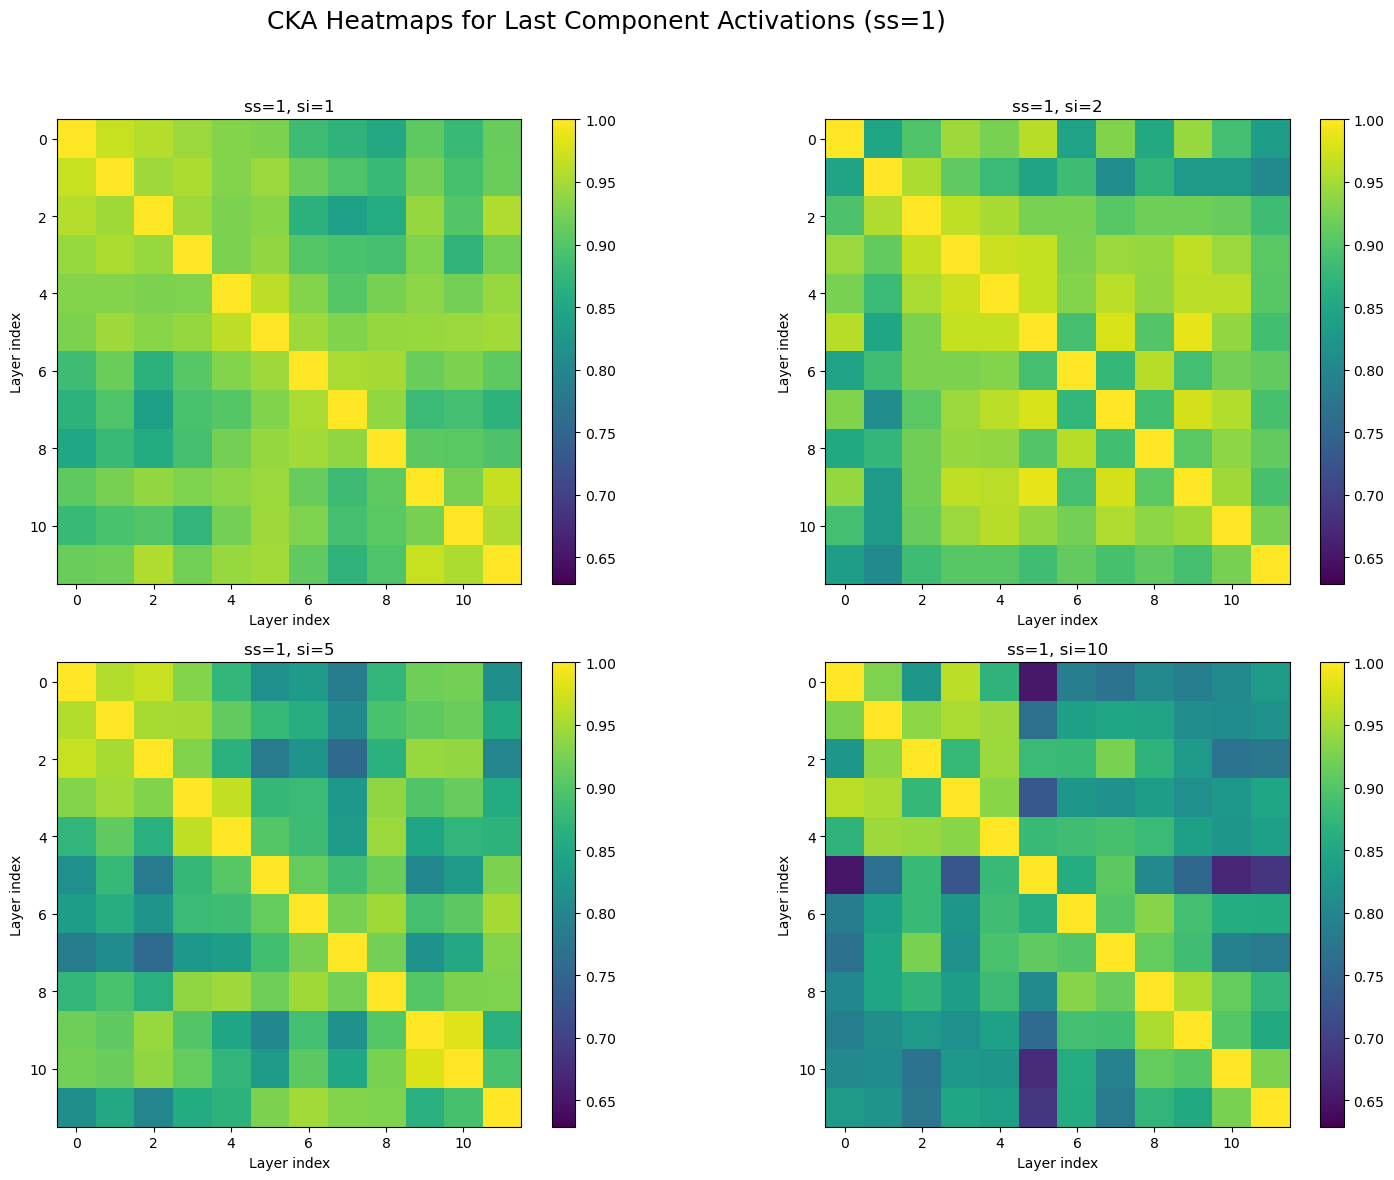

In [156]:
###########################################
# Model Paths
###########################################
model_standard = "model_20250218_170429_bl12_ts1_bs128.pth"
checkpoint_paths = [
    "model_20250218_171155_bl12_ts1_bs128_si10_ss1.pth",
    "model_20250218_181432_bl12_ts1_bs128_si5_ss1.pth",
    "model_20250218_191848_bl12_ts1_bs128_si2_ss1.pth",
    "model_20250218_202230_bl12_ts1_bs128_si1_ss1.pth",
    "model_20250218_212821_bl12_ts1_bs128_si10_ss2.pth",
    "model_20250218_223241_bl12_ts1_bs128_si5_ss2.pth",
    "model_20250218_233527_bl12_ts1_bs128_si2_ss2.pth",
    "model_20250219_003935_bl12_ts1_bs128_si1_ss2.pth",
    "model_20250219_014311_bl12_ts1_bs128_si10_ss3.pth",
    "model_20250219_024647_bl12_ts1_bs128_si5_ss3.pth",
    "model_20250219_035025_bl12_ts1_bs128_si2_ss3.pth",
    "model_20250219_045353_bl12_ts1_bs128_si1_ss3.pth",
    "model_20250219_055732_bl12_ts1_bs128_si10_ss4.pth",
    "model_20250219_070042_bl12_ts1_bs128_si5_ss4.pth",
    "model_20250219_080432_bl12_ts1_bs128_si2_ss4.pth",
    "model_20250219_090855_bl12_ts1_bs128_si1_ss4.pth"
]

###########################################
# Example Usage
###########################################
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Compute the dictionary of CKA matrices for the last component activations.
    cka_dict_last = compute_cka_matrices_dict_last(checkpoint_paths, device=device, alpha=1.0)
    
    # For example, plot the heatmaps for swapping strategy ss=1
    ss_value_to_plot = 1
    plot_cka_heatmap_by_ss(ss_value_to_plot, cka_dict_last)

In [157]:
###########################################
# Plotting Functions
###########################################
def plot_cka_matrices(cka_matrices, titles, vmin, vmax, ss_value):
    """
    Plots a 2x2 grid of CKA heatmaps using the provided list of matrices.
    All heatmaps share the same color scale (vmin, vmax).
    """
    # Create a 2x2 grid for the subplots.
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Plot each matrix in its subplot.
    for idx in range(4):
        if idx < len(cka_matrices):
            im = axes[idx].imshow(cka_matrices[idx], interpolation="nearest", cmap="viridis", vmin=vmin, vmax=vmax)
            axes[idx].set_title(titles[idx])
            axes[idx].set_xlabel("Layer index")
            axes[idx].set_ylabel("Layer index")
            fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
        else:
            # If there are fewer than 4 matrices, hide the remaining axes.
            axes[idx].axis("off")
    
    plt.suptitle(f"CKA Heatmaps for Energy Gradients (ss={ss_value})", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_filename = f"et_ss{ss_value}_cka_heatmap_grad.pdf"
    plt.savefig(save_filename, format='pdf')
    plt.show()

def plot_cka_heatmap_by_ss(ss_value, cka_dict, global_vmin=None, global_vmax=None):
    """
    For a given swapping strategy (ss_value), extracts up to 4 computed CKA matrices
    from cka_dict, computes the overall color scale if not provided, and plots them in a 2x2 grid.
    """
    if ss_value not in cka_dict or len(cka_dict[ss_value]) == 0:
        print(f"No CKA matrices found for ss = {ss_value}")
        return
    
    # Select up to 4 checkpoints to ensure a 2x2 grid.
    selected = cka_dict[ss_value][:4]
    matrices = [item[1] for item in selected]
    titles = [item[2] for item in selected]
    
    # Compute overall global min and max if not provided.
    if global_vmin is None or global_vmax is None:
        all_matrices = []
        for group in cka_dict.values():
            for (_, m, _) in group:
                all_matrices.append(m)
        global_vmin = min(m.min() for m in all_matrices)
        global_vmax = max(m.max() for m in all_matrices)
    
    plot_cka_matrices(matrices, titles, vmin=global_vmin, vmax=global_vmax, ss_value=ss_value)


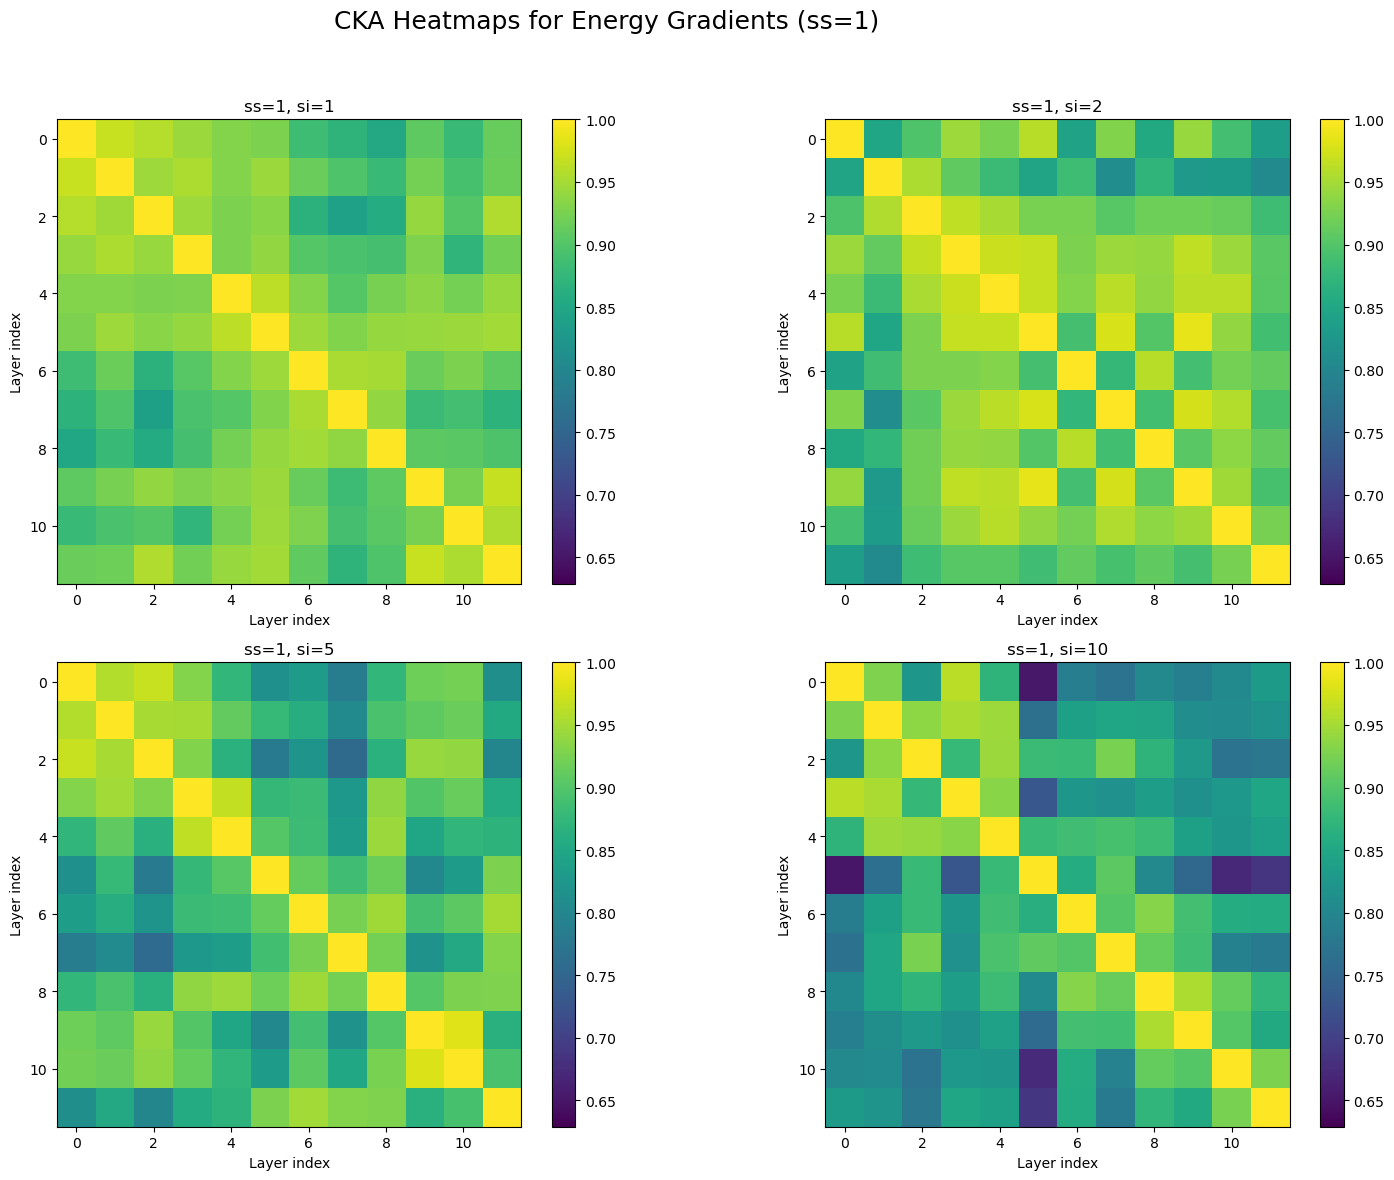

In [158]:
plot_cka_heatmap_by_ss(1, cka_dict_last)

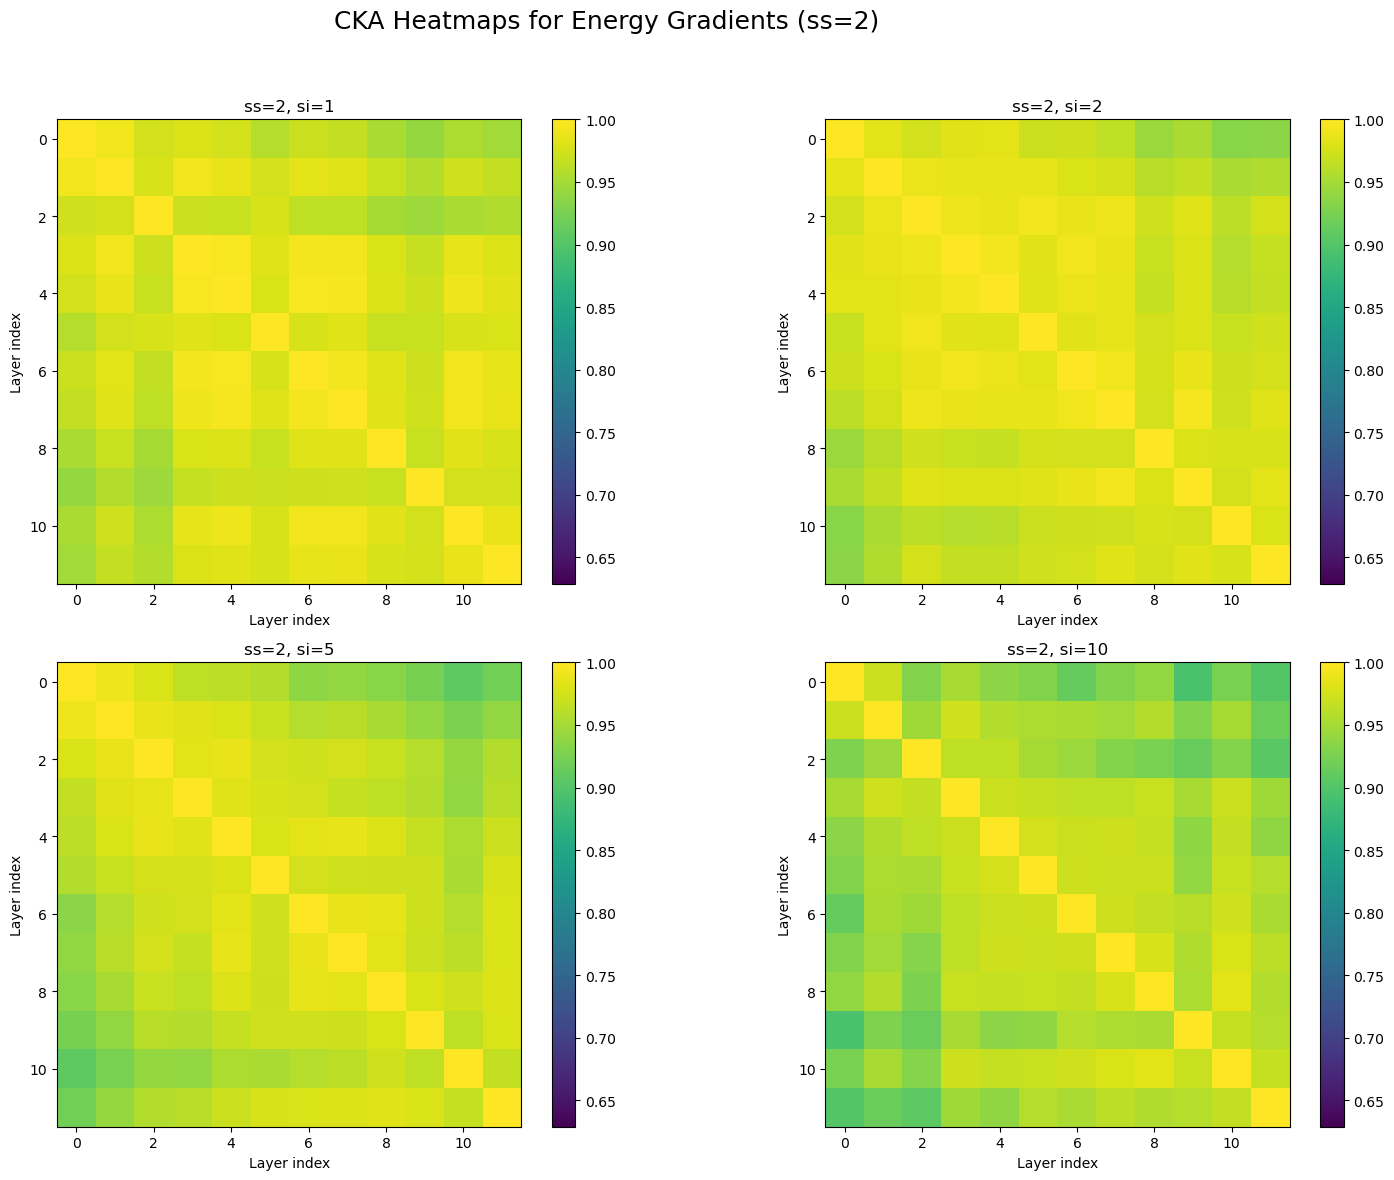

In [159]:
plot_cka_heatmap_by_ss(2, cka_dict_last)

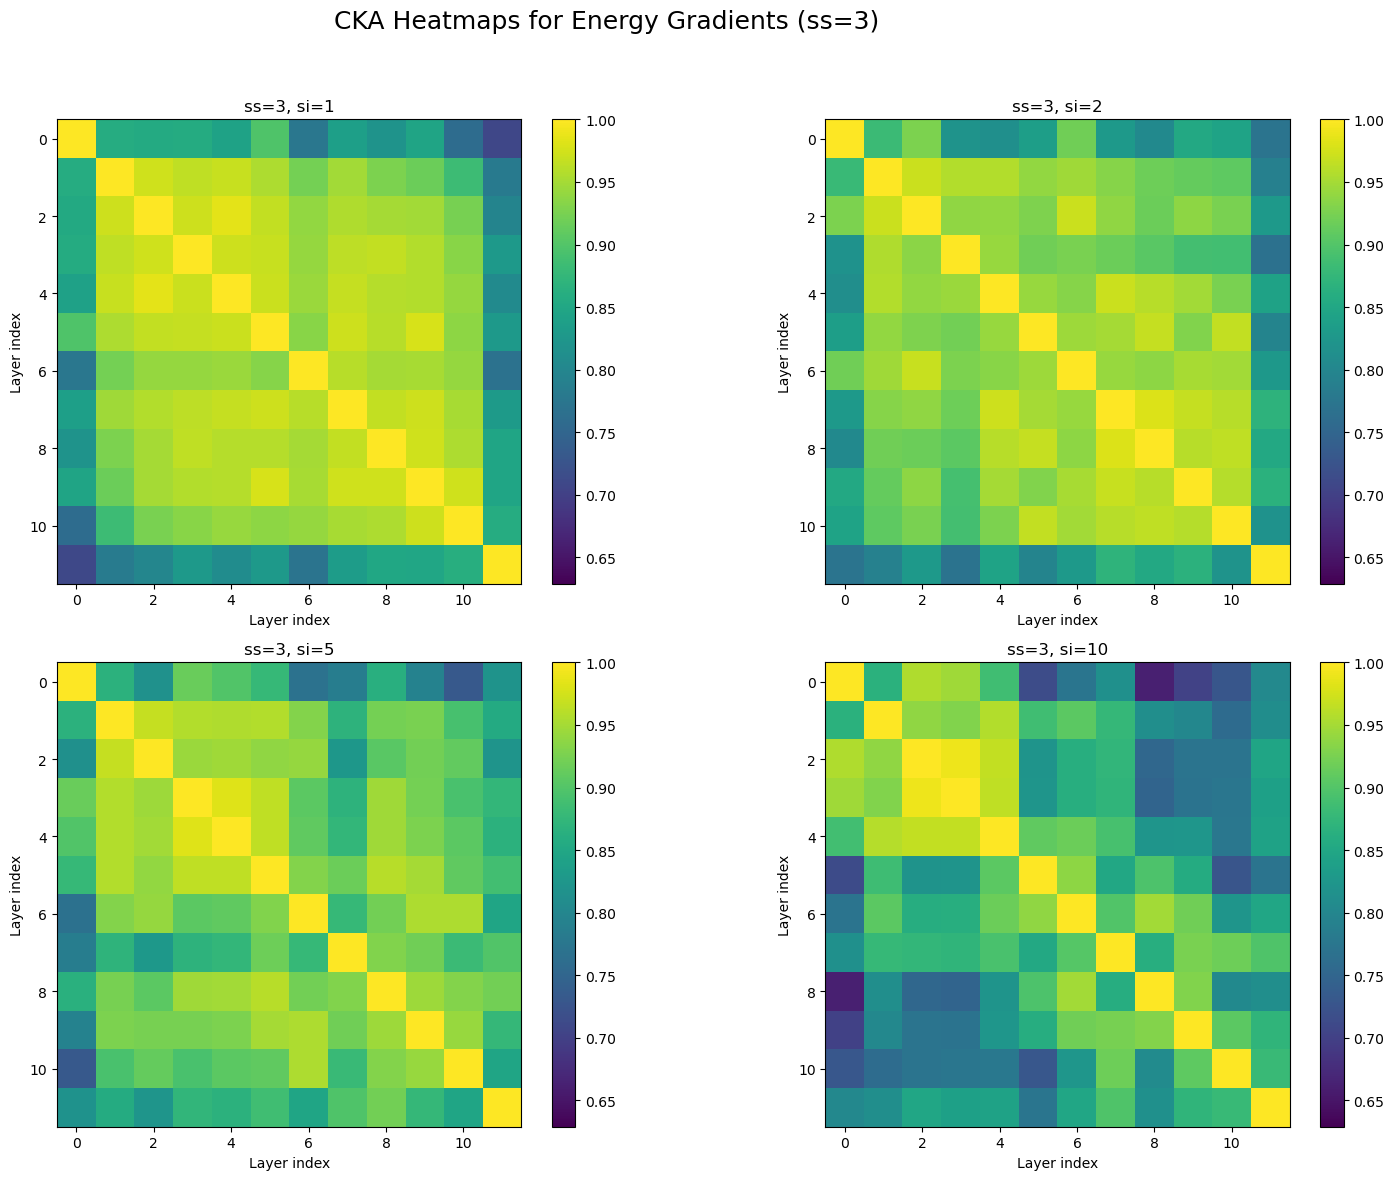

In [160]:
plot_cka_heatmap_by_ss(3, cka_dict_last)

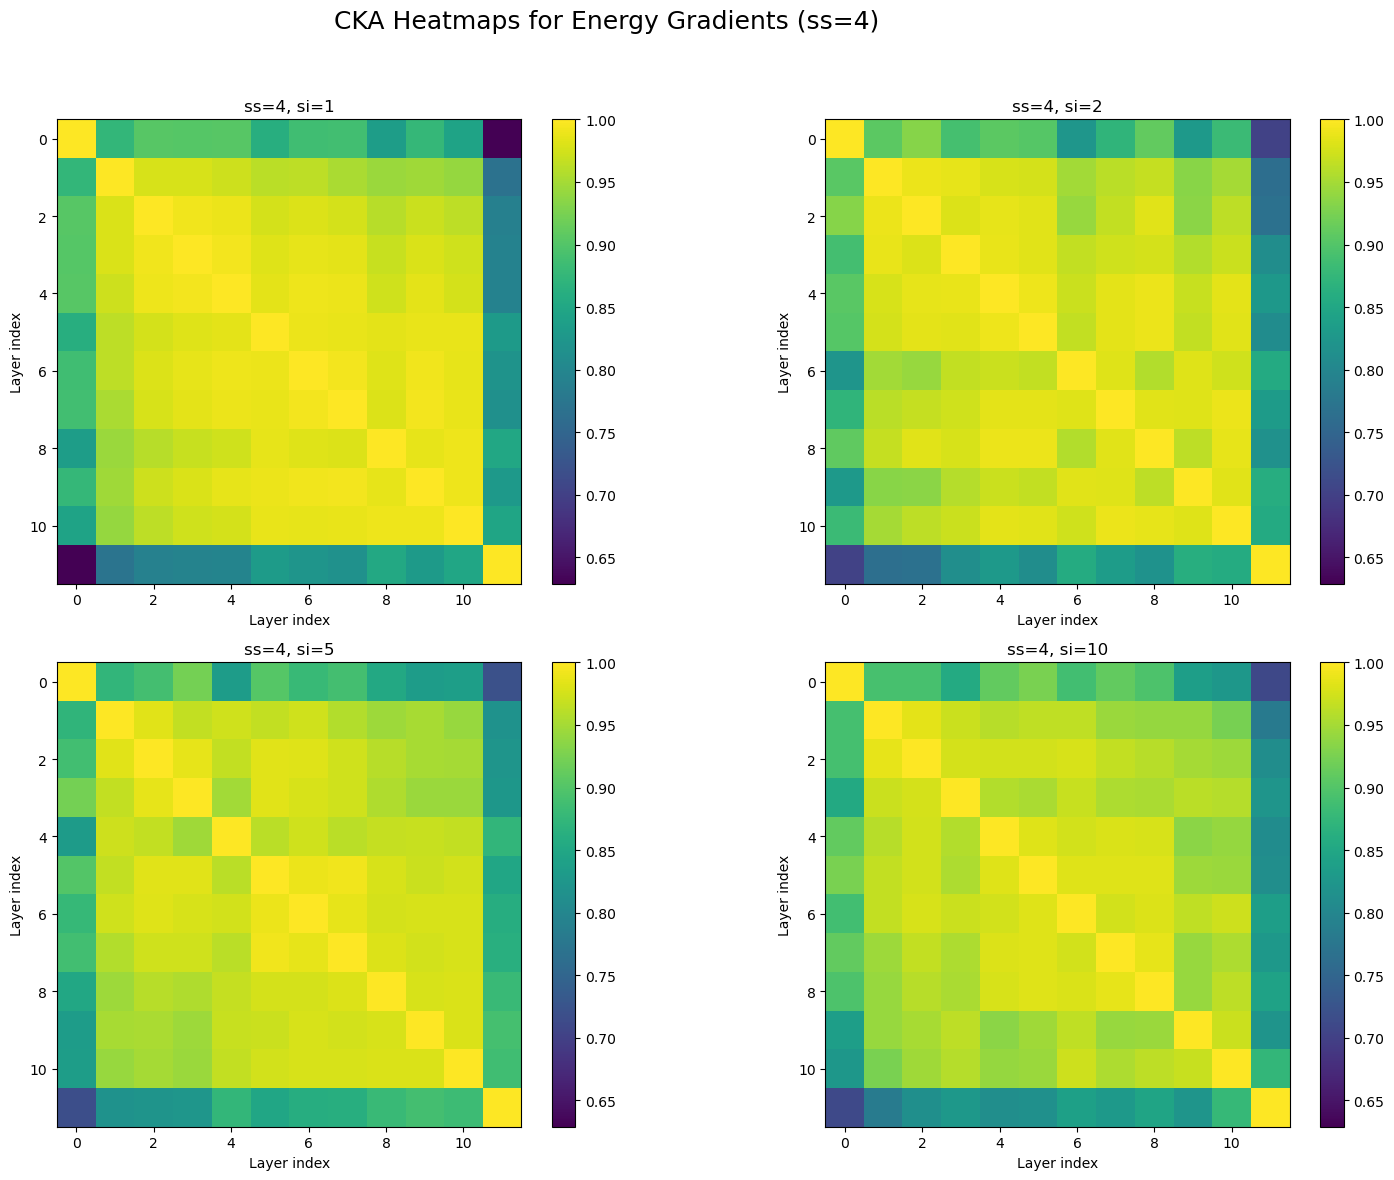

In [161]:
plot_cka_heatmap_by_ss(4, cka_dict_last)